In [73]:
import numpy as np
import matplotlib.pyplot as plt
import cv2

import pandas as pd

from scipy.io import loadmat

import glob

In [74]:
import numpy as np

class cnt_mat_fig:

    '''
    This class is used to read in and process CNT .fig matlab files.
    These .fig files were produced by 
    '''
    
    def __init__(self, mat_fig, set_number):
        
        '''
        Instantiates a cnt_mat_fig from a .fig matlab output file.
        
        '''
        
        line_data = mat_fig["hgS_070000"][0][0][3][0][0][3][2::2]
        
        line_list = []
        center_list = []
        diameters_list = []
        
        import numpy as np
        
        for line in line_data:
            
            x1,x2 = [int(i) for i in line[0][2][0][0][2][0]]
            y1,y2 = [int(i) for i in line[0][2][0][0][3][0]]
        
            line_list.append([x1,y1,x2,y2])
            center_list.append([int((x1+x2)/2), int((y1+y2)/2)])
            diameters_list.append(np.sqrt((x2-x1)**2 + (y2-y1)**2))
        
        self.lines_ = line_list
        self.centers_ = center_list
        self.diameters_ = diameters_list
        #img = mat_fig["hgS_070000"][0][0][3][0][0][3][0][0][2][0][0][1][:,:,0]
        #self.img_ = np.reshape(img, [*img.shape,1]) # add extra dimension to make keras happy
        self.img_ = mat_fig["hgS_070000"][0][0][3][0][0][3][0][0][2][0][0][1][:,:,0]
        #self.file_name_ = mat_fig["hgS_070000"][0][0][3][0][0][3][9][0][2][0][0][8][0]
        
        mat_fig_str = str(mat_fig["hgS_070000"][0][0][3][0][0][3])
        jpg_index = mat_fig_str.find('.jpg')
                
        self.file_name_ = mat_fig_str[jpg_index-2:jpg_index+4]
        
        self.set_number_ = str(set_number)
        
    def get_ROIs(self,length = 32):
        '''
        Copys length x length square images bought each measurement center. 
        Default length is 32.
        '''
        
        ROI_list = [] # list of length x length images
        
        for center in self.centers_:
            
            l = int(length/2)
            x = center[0]
            y = center[1]
            ROI_list.append(self.img_[y - l : y + l, x - l : x + l])
            
        
        return ROI_list
    
    def get_negs(self,length = 32,n = 5):
        '''
        Returns n length x length images with no suitable CNTs (negative images) from the original image. 
        Will not return any images that are within length/2 of any measurement point.
        length should be set to the same length in get_ROIs.
        '''
        
        neg_list = []
        
        l = int(length/2)
        
        def overlap(p1,p2,l):
            x1,y1 = p1
            x2,y2 = p2
            
            if np.abs(x1-x2) < l:
                return 1
            if np.abs(y1-y2) < l:
                return 1
            else:
                return 0
        
        y_px,x_px = self.img_.shape
        
        for i in range(n):
                       
            overlapped = True
            
            while overlapped:
            
                overlapped = False
            
                # choose random x and y for the negative image that are at least l (length/2) away from an edge
                x = int(np.random.rand()*(x_px-2*l)+l)
                y = int(np.random.rand()*(y_px-2*l)+l)

                for center in self.centers_:
                    if overlap([x,y],center,l): 
                        overlapped = True # if any center points are too close to (x,y), try again
                        break
            
            neg_list.append(self.img_[y - l : y + l, x - l : x + l])
        
        return neg_list

In [93]:
def add_cnt_data(df, cnf, flip = True, rotate = True,n_negs = 32, length = 128):
    
    ROI = cnf.get_ROIs(length = length)
    diams = cnf.diameters_
    neg = cnf.get_negs(length = length, n = n_negs)
    
    n_ROI = len(ROI)
    
    if n_ROI:
        
        # use flip_rot() to augment the positive data
        aug_ROI = flip_rot(ROI, flip = flip, rotate = rotate) 
        # enabling both flip and rotate will increase the positive samples by a factor of 8

        aug_fac = int(len(aug_ROI) / n_ROI)

        img_suf = []


        for num in range(1,n_ROI+1):
            for perm in range(aug_fac):
                img_suf.append(str(num) + '-' +str(perm))

        aug_diams = [] # diameters for the augmented ROIs (duplicates of originals)

        for diam in diams: # since the number of ROIs has expanded by a aug_fac, we need to expand diams, too
            for _ in range(aug_fac):
                aug_diams.append(diam)

        for i in range(len(aug_ROI)):
            new_rec = {}
            new_rec['img'] = aug_ROI[i]
            new_rec['name'] = cnf.set_number_ + '_' + cnf.file_name_ + '-' + img_suf[i]
            new_rec['diameter'] = aug_diams[i]
            new_rec['has_cnt'] = 1

            df = df.append(new_rec, ignore_index = True)
        
        
    for i in range(len(neg)):
        new_rec = {}
        new_rec['img'] = neg[i]
        new_rec['name'] = cnf.set_number_ + '_' + cnf.file_name_ + '_neg-' + str(i)
        new_rec['diameter'] = 0
        new_rec['has_cnt'] = 0

        df = df.append(new_rec, ignore_index = True)
        
    return df
        
def flip_rot(imgs,flip = True, rotate = True):
    
    '''
    Takes a list of images, imgs, and returns a list of images imgs_out,
    where each image is a rotatation, flip, or both of an image in imgs.
    '''
    
    imgs_out = []#np.zeros(len(imgs)*(flip+1)*(rotate*3 +1))
    
    for img in imgs:
        
        for rot in range(4):
            
            imgs_out.append(img)
            
            if flip:
                imgs_out.append(np.flip(img))
            
            img = img.T
            
            if rot == 0 and rotate == False:
                break
    return imgs_out

# make_dicts is UNTESTED! Ignore!

In [76]:
path_to_dir = "../cnt_data/TEM-2018-10-22/LX0731R1-FMES195/Measurments/"

meas1 = loadmat(path_to_dir + "meas1.fig")
m1 = cnt_mat_fig(meas1, 195)

In [77]:
column_names = ['name','img','diameter','has_cnt']

df = pd.DataFrame(columns = column_names)
df.head()

,name,img,diameter,has_cnt


In [78]:
df = df.append(add_cnt_data(df, m1))

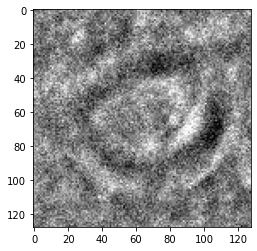

In [80]:
plt.imshow(df.iloc[32,1],cmap = 'gray')

In [81]:
dir_path = 'C:\\Users\\Max\\OneDrive\\git_repos\\cnt_data\\TEM-2018-10-22\\LX0731R1-FMES195\\Measurments\\'
f_list_195 = glob.glob(dir_path+'*.fig')[1:]

In [82]:
path_to_dir = "../cnt_data/TEM-2018-10-22/LX0731R1-FMES195/Measurments/"

meas1 = loadmat(path_to_dir + "meas1.fig")
m1 = cnt_mat_fig(meas1, 195)

In [98]:
def read_dir(df,path,set_number,flip = True, rotate = True,n_negs = 64, length = 128, n_files = 0):
    
    if n_files: f_list = glob.glob(path+'*.fig')[1:n_files+1]    
    else: f_list = glob.glob(path+'*.fig')[1:]
    
    for file_path in f_list:

        fig_file = loadmat(file_path)
        
        fig_obj = cnt_mat_fig(fig_file, set_number)
        
        df = add_cnt_data(df, fig_obj,
                              flip = flip,
                              rotate = rotate,
                              n_negs = n_negs,
                              length = length)
                              
        #del fig_file
        #del fig_obj
        
        print(len(df))
        
    return df


In [102]:
%%time

column_names = ['name','img','diameter','has_cnt']
df = pd.DataFrame(columns = column_names)

path_193 = "../cnt_data/TEM-2018-10-22/LX0724R1-FMES193/Measurments/"
path_194 = "../cnt_data/TEM-2018-10-22/LX0730R1-FMES194/Measurments/"
path_195 = "../cnt_data/TEM-2018-10-22/LX0731R1-FMES195/Measurments/"

df = df.append(read_dir(df, path_193, set_number=193,flip = False, rotate = False,n_negs = 8), ignore_index = True)
df = df.append(read_dir(df, path_194, set_number=194,flip = False, rotate = False,n_negs = 8), ignore_index = True)
df = df.append(read_dir(df, path_195, set_number=195,flip = False, rotate = False,n_negs = 8), ignore_index = True)
df.to_pickle('3_datasets_2018_10_22_no_aug')

14
27
40
52
64
79
95
115
130
144
155
163
175
183
194
208
218
230
240
250
272
292
304
318
330
349
369
383
411
420
434
443
457
468
482
504
523
540
557
574
593
609
623
877
895
914
929
941
951
961
972
983
998
1018
1028
1043
1058
1070
1085
1100
1113
1124
1136
1155
1167
1182
Wall time: 55.9 s
